In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('ramen-ratings.xlsx')
df.sample(5)

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
2426,154,Nissin,Creamy Chicken,Cup,USA,1.75,NaN
2135,445,iNoodle,Taiwan Style Chow Mein,Pack,Taiwan,2.25,NaN
17,2563,Yamachan,Tokyo Shoyu Ramen,Pack,USA,5,NaN
495,2085,Fuku,Superior Soup Instant Rice Vermicelli,Bowl,Hong Kong,5,NaN
1787,793,Mr. Noodles,Spicy Beef,Pack,Canada,1.75,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review #  2580 non-null   int64 
 1   Brand     2580 non-null   object
 2   Variety   2580 non-null   object
 3   Style     2578 non-null   object
 4   Country   2580 non-null   object
 5   Stars     2580 non-null   object
 6   Top Ten   41 non-null     object
dtypes: int64(1), object(6)
memory usage: 141.2+ KB


In [4]:
df = df.drop(['Top Ten', 'Review #', 'Variety'], axis = 1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Brand    2580 non-null   object
 1   Style    2578 non-null   object
 2   Country  2580 non-null   object
 3   Stars    2580 non-null   object
dtypes: object(4)
memory usage: 80.8+ KB


In [6]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2578 entries, 0 to 2579
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Brand    2578 non-null   object
 1   Style    2578 non-null   object
 2   Country  2578 non-null   object
 3   Stars    2578 non-null   object
dtypes: object(4)
memory usage: 100.7+ KB


In [7]:
df['Stars'].unique()

array([3.75, 1, 2.25, 2.75, 4.75, 4, 0.25, 2.5, 5, 4.25, 4.5, 3.5,
       'Unrated', 1.5, 3.25, 2, 0, 3, 0.5, 3.8, 4.3, 2.3, 3.3, 1.75, 0.75,
       1.25, 1.1, 2.1, 0.9, 3.1, 4.125, 3.125, 2.125, 2.9, 0.1, 2.8, 3.7,
       3.4, 3.6, 2.85, 3.2, 3.65, 1.8], dtype=object)

In [8]:
unrated = df[df['Stars'] == 'Unrated']
unrated

,Brand,Style,Country,Stars
32,Ottogi,Pack,South Korea,Unrated
122,Samyang Foods,Pack,South Korea,Unrated
993,Mi E-Zee,Pack,Malaysia,Unrated


In [9]:
df = df[df['Stars'] != 'Unrated']
df['Stars'] = pd.to_numeric(df['Stars'], errors='coerce')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2575 entries, 0 to 2579
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Brand    2575 non-null   object 
 1   Style    2575 non-null   object 
 2   Country  2575 non-null   object 
 3   Stars    2575 non-null   float64
dtypes: float64(1), object(3)
memory usage: 100.6+ KB


In [10]:
umbral = 3.5

df['Stars'] = (df['Stars'] > umbral).astype(bool)


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2575 entries, 0 to 2579
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Brand    2575 non-null   object
 1   Style    2575 non-null   object
 2   Country  2575 non-null   object
 3   Stars    2575 non-null   bool  
dtypes: bool(1), object(3)
memory usage: 83.0+ KB


In [12]:
country = sorted(df['Country'].unique())
country

['Australia',
 'Bangladesh',
 'Brazil',
 'Cambodia',
 'Canada',
 'China',
 'Colombia',
 'Dubai',
 'Estonia',
 'Fiji',
 'Finland',
 'Germany',
 'Ghana',
 'Holland',
 'Hong Kong',
 'Hungary',
 'India',
 'Indonesia',
 'Japan',
 'Malaysia',
 'Mexico',
 'Myanmar',
 'Nepal',
 'Netherlands',
 'Nigeria',
 'Pakistan',
 'Philippines',
 'Poland',
 'Sarawak',
 'Singapore',
 'South Korea',
 'Sweden',
 'Taiwan',
 'Thailand',
 'UK',
 'USA',
 'United States',
 'Vietnam']

In [13]:
df['Country'] = df['Country'].replace('USA', 'United States')
df['Country'] = df['Country'].replace('Holland', 'Netherlands')

In [14]:
style = sorted(df['Style'].unique())
style

['Bar', 'Bowl', 'Box', 'Can', 'Cup', 'Pack', 'Tray']

In [15]:
df['Brand'].count().sum()

2575

In [16]:
brand_counts = df['Brand'].value_counts(normalize=True)

popular_threshold = brand_counts.quantile(0.99)
known_threshold = brand_counts.quantile(0.70)

def classify_brand(frequency):
    if frequency >= popular_threshold:
        return 'Muy conocida'
    elif frequency >= known_threshold:
        return 'Conocida'
    else:
        return 'Desconocida'

df['Brand_Category'] = df['Brand'].map(brand_counts.apply(classify_brand))
df.drop('Brand', axis = 1, inplace = True)

In [17]:
import pycountry_convert as pc

def get_continent(country_name):
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except:
        return None
df['Continent'] = df['Country'].apply(get_continent)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2575 entries, 0 to 2579
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Style           2575 non-null   object
 1   Country         2575 non-null   object
 2   Stars           2575 non-null   bool  
 3   Brand_Category  2575 non-null   object
 4   Continent       2500 non-null   object
dtypes: bool(1), object(4)
memory usage: 103.1+ KB


In [19]:
df.dropna(inplace = True)
df.drop('Country', axis = 1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2500 entries, 0 to 2579
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Style           2500 non-null   object
 1   Stars           2500 non-null   bool  
 2   Brand_Category  2500 non-null   object
 3   Continent       2500 non-null   object
dtypes: bool(1), object(3)
memory usage: 80.6+ KB


In [20]:
brand_category_counts = df['Brand_Category'].value_counts()
brand_category_counts

Brand_Category
Conocida        1452
Muy conocida     626
Desconocida      422
Name: count, dtype: int64

In [21]:
df = pd.get_dummies(df, columns=['Continent'], prefix='Continent')
df = pd.get_dummies(df, columns=['Brand_Category'], prefix='Brand_Category')
df = pd.get_dummies(df, columns=['Style'], prefix='Style')
df.sample(10)

,Stars,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Brand_Category_Conocida,Brand_Category_Desconocida,Brand_Category_Muy conocida,Style_Bar,Style_Bowl,Style_Box,Style_Can,Style_Cup,Style_Pack,Style_Tray
405,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False
284,False,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False
867,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False
277,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False
2473,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False
553,True,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,False
1780,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False
1482,True,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False
2208,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False
258,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2500 entries, 0 to 2579
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Stars                        2500 non-null   bool 
 1   Continent_Africa             2500 non-null   bool 
 2   Continent_Asia               2500 non-null   bool 
 3   Continent_Europe             2500 non-null   bool 
 4   Continent_North America      2500 non-null   bool 
 5   Continent_Oceania            2500 non-null   bool 
 6   Continent_South America      2500 non-null   bool 
 7   Brand_Category_Conocida      2500 non-null   bool 
 8   Brand_Category_Desconocida   2500 non-null   bool 
 9   Brand_Category_Muy conocida  2500 non-null   bool 
 10  Style_Bar                    2500 non-null   bool 
 11  Style_Bowl                   2500 non-null   bool 
 12  Style_Box                    2500 non-null   bool 
 13  Style_Can                    2500 non-null   bool 
 1

In [23]:
df.sample(10)

,Stars,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Brand_Category_Conocida,Brand_Category_Desconocida,Brand_Category_Muy conocida,Style_Bar,Style_Bowl,Style_Box,Style_Can,Style_Cup,Style_Pack,Style_Tray
2538,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False
1790,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False
1465,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True
562,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False
2259,True,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False
1085,True,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False
418,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False
958,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False
1376,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False
1509,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False


In [24]:
df['Stars'].value_counts('%')

Stars
True     0.5828
False    0.4172
Name: proportion, dtype: float64

In [25]:
X = df.drop('Stars', axis =1)
y = df['Stars']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       False       0.66      0.22      0.34       209
        True       0.62      0.92      0.74       291

    accuracy                           0.63       500
   macro avg       0.64      0.57      0.54       500
weighted avg       0.64      0.63      0.57       500



In [26]:
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)

SVC(probability=True)

Accuracy: 0.638
Classification Report:
              precision    recall  f1-score   support

       False       0.66      0.27      0.39       209
        True       0.63      0.90      0.74       291

    accuracy                           0.64       500
   macro avg       0.65      0.59      0.56       500
weighted avg       0.65      0.64      0.59       500

AUC-ROC: 0.5923724493990365


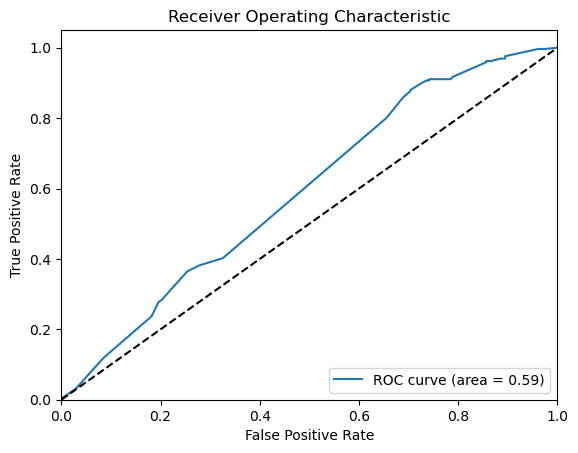

In [27]:
y_pred = svm_model.predict(X_test)
y_proba = svm_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{class_report}")
print(f"AUC-ROC: {roc_auc}")


fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()